# Train CNN with MFCCs


## cnn_mfccs_2


Inspired by https://medium.com/@diego-rios/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7


Import the necessary libraries


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import os
import sys
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu118
True


Set the seed for reproducibility


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'cnn_mfccs_zero_2'

train_csv = '../../../data/mfcc_train_dataset.csv'
test_csv = '../../../data/mfcc_test_dataset.csv'
val_csv = '../../../data/mfcc_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MfccDataset import MFCCDataset
from cnn.pipeline.Pipeline import Pipeline

Import the model


In [7]:
from cnn.models.architectures.CNNMFCCs2 import CNNMFCCs2

model = CNNMFCCs2()

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNMFCCs2(
  (conv1): Conv1d(40, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

Visualize the model


In [8]:
summary(model, (40, 172))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 172]           3,872
       BatchNorm1d-2              [-1, 32, 172]              64
            Conv1d-3               [-1, 64, 86]           6,208
       BatchNorm1d-4               [-1, 64, 86]             128
            Conv1d-5              [-1, 128, 43]          24,704
       BatchNorm1d-6              [-1, 128, 43]             256
            Conv1d-7              [-1, 256, 21]          98,560
       BatchNorm1d-8              [-1, 256, 21]             512
 AdaptiveAvgPool1d-9               [-1, 256, 1]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 9]           1,161
Total params: 168,361
Trainable params:

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([])

num_epochs = 100

Prepare datasets and dataloaders


In [10]:
trainset = MFCCDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MFCCDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MFCCDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 56.21it/s, Loss=1.0238416194915771, Elapsed=1.5171s, ETA=0.0000s]


Epoch 1 completed in 11.8236s
Train Loss: 1.309279179814234 - Train Accuracy: 42.91852287374777
Validation Loss: 1.139904489517212 - Validation Accuracy: 49.16631490080203

Epoch 2/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 72.19it/s, Loss=0.9155581593513489, Elapsed=1.2291s, ETA=0.0000s]


Epoch 2 completed in 5.9339s
Train Loss: 1.0222267617035463 - Train Accuracy: 54.57814160692883
Validation Loss: 0.9454766480127971 - Validation Accuracy: 60.38412832418742

Epoch 3/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 72.52it/s, Loss=0.8946291208267212, Elapsed=1.2250s, ETA=0.0000s]

Epoch 3 completed in 6.0557s
Train Loss: 0.9226032903773247 - Train Accuracy: 59.32927794486782
Validation Loss: 0.8350427428881327 - Validation Accuracy: 63.877163360067534

Epoch 4/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.67it/s, Loss=0.8429996967315674, Elapsed=1.2877s, ETA=0.0000s]

Epoch 4 completed in 6.1591s
Train Loss: 0.8619565316018342 - Train Accuracy: 61.96151149906153
Validation Loss: 0.84298193136851 - Validation Accuracy: 64.40481215702827

EarlyStopping counter: 1/7
Epoch 5/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.07it/s, Loss=1.1945544481277466, Elapsed=1.2616s, ETA=0.0000s]

Epoch 5 completed in 6.0899s
Train Loss: 0.8246422864798176 - Train Accuracy: 63.67336785690056
Validation Loss: 0.8447733489672343 - Validation Accuracy: 63.67665681722245

EarlyStopping counter: 2/7
Epoch 6/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.21it/s, Loss=0.9832533597946167, Elapsed=1.3072s, ETA=0.0000s]

Epoch 6 completed in 6.3236s
Train Loss: 0.7860619034725806 - Train Accuracy: 65.49603129734741
Validation Loss: 0.901708189646403 - Validation Accuracy: 61.935415787252005

EarlyStopping counter: 3/7
Epoch 7/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.90it/s, Loss=0.609086275100708, Elapsed=1.2513s, ETA=0.0000s] 


Epoch 7 completed in 6.2011s
Train Loss: 0.7538058528665862 - Train Accuracy: 66.78275027701771
Validation Loss: 0.7850730180740356 - Validation Accuracy: 67.1802448290418

Epoch 8/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 69.20it/s, Loss=0.6759719848632812, Elapsed=1.2443s, ETA=0.0000s]

Epoch 8 completed in 6.4914s
Train Loss: 0.7320779306178837 - Train Accuracy: 68.033287352163
Validation Loss: 0.7511894218126933 - Validation Accuracy: 69.61798227100043

Epoch 9/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.93it/s, Loss=0.5334519743919373, Elapsed=1.2670s, ETA=0.0000s]

Epoch 9 completed in 6.3853s
Train Loss: 0.709378590387416 - Train Accuracy: 68.82250514461455
Validation Loss: 0.7524672571818034 - Validation Accuracy: 67.87674124102998

EarlyStopping counter: 1/7
Epoch 10/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.92it/s, Loss=0.554838240146637, Elapsed=1.2699s, ETA=0.0000s] 

Epoch 10 completed in 6.2011s
Train Loss: 0.6938863613701969 - Train Accuracy: 69.56649555640985
Validation Loss: 0.7182576537132264 - Validation Accuracy: 66.58927817644576

Epoch 11/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.71it/s, Loss=0.5994768738746643, Elapsed=1.3429s, ETA=0.0000s]

Epoch 11 completed in 6.7129s
Train Loss: 0.6730251525867881 - Train Accuracy: 70.45295221727234
Validation Loss: 0.7030938625335693 - Validation Accuracy: 70.20894892359647

Epoch 12/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.83it/s, Loss=0.6290682554244995, Elapsed=1.3052s, ETA=0.0000s]


Epoch 12 completed in 6.2187s
Train Loss: 0.6584327065014426 - Train Accuracy: 71.16076072454264
Validation Loss: 0.7086283564567566 - Validation Accuracy: 71.27479949345715

EarlyStopping counter: 1/7
Epoch 13/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 65.92it/s, Loss=0.5579084157943726, Elapsed=1.3302s, ETA=0.0000s]

Epoch 13 completed in 6.3572s
Train Loss: 0.641466367279174 - Train Accuracy: 71.72384161371295
Validation Loss: 0.7341659649213155 - Validation Accuracy: 70.42000844238075

EarlyStopping counter: 2/7
Epoch 14/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 68.94it/s, Loss=0.5054373145103455, Elapsed=1.2793s, ETA=0.0000s] 

Epoch 14 completed in 6.4081s
Train Loss: 0.6294149423093465 - Train Accuracy: 72.42712738291762
Validation Loss: 0.6777900966008504 - Validation Accuracy: 70.42000844238075

Epoch 15/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.58it/s, Loss=0.4727877676486969, Elapsed=1.3167s, ETA=0.0000s]

Epoch 15 completed in 6.2765s
Train Loss: 0.6106647225473657 - Train Accuracy: 73.12589041405667
Validation Loss: 0.7165292100111643 - Validation Accuracy: 70.8843393837062

EarlyStopping counter: 1/7
Epoch 16/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.74it/s, Loss=0.2257896214723587, Elapsed=1.2715s, ETA=0.0000s] 

Epoch 16 completed in 6.1195s
Train Loss: 0.6055455841770062 - Train Accuracy: 73.28418624635354
Validation Loss: 0.7361367517709732 - Validation Accuracy: 69.4596876319122

EarlyStopping counter: 2/7
Epoch 17/100



Validating: 100%|██████████| 75/75 [00:01<00:00, 70.09it/s, Loss=0.5434034466743469, Elapsed=1.2294s, ETA=0.0000s]


Epoch 17 completed in 6.4476s
Train Loss: 0.5865416647381865 - Train Accuracy: 74.09601772913321
Validation Loss: 0.7010526784261067 - Validation Accuracy: 71.86576614605319

EarlyStopping counter: 3/7
Epoch 18/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.10it/s, Loss=0.2022562474012375, Elapsed=1.3954s, ETA=0.0000s] 


Epoch 18 completed in 6.4357s
Train Loss: 0.5764702669630161 - Train Accuracy: 74.39677981049726
Validation Loss: 0.6954357304175695 - Validation Accuracy: 72.60447446179823

EarlyStopping counter: 4/7
Epoch 19/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 69.65it/s, Loss=0.3144591152667999, Elapsed=1.2407s, ETA=0.0000s] 


Epoch 19 completed in 6.1799s
Train Loss: 0.5638100834767943 - Train Accuracy: 74.90784921191289
Validation Loss: 0.7023014561335246 - Validation Accuracy: 72.41452089489236

EarlyStopping counter: 5/7
Epoch 20/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 71.64it/s, Loss=0.2566530406475067, Elapsed=1.2452s, ETA=0.0000s] 


Epoch 20 completed in 6.1473s
Train Loss: 0.5559453628311267 - Train Accuracy: 75.1611225435879
Validation Loss: 0.6798572591940562 - Validation Accuracy: 72.6466863655551

EarlyStopping counter: 6/7
Epoch 21/100


Validating: 100%|██████████| 75/75 [00:01<00:00, 64.32it/s, Loss=0.6037015914916992, Elapsed=1.3670s, ETA=0.0000s] 


Epoch 21 completed in 6.1826s
Train Loss: 0.5354435096758638 - Train Accuracy: 76.0905452160738
Validation Loss: 0.6793470394611358 - Validation Accuracy: 74.32460953989025

EarlyStopping counter: 7/7
🔁 Early stopping triggered!


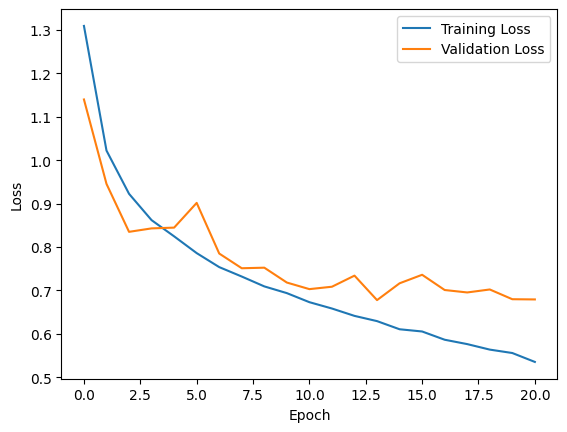

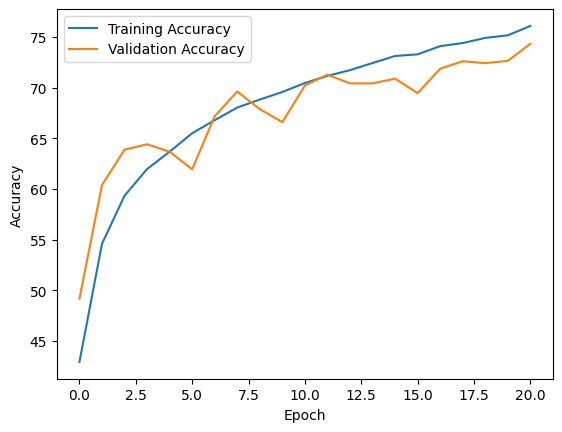

Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:01<00:00, 42.02it/s]


Test Accuracy: 0.7328
Test Precision: 0.7468
Test Recall: 0.7328
Test F1-score: 0.7352

              precision    recall  f1-score   support

       Anger       0.77      0.75      0.76       916
       Bored       0.78      0.83      0.80      1098
     Disgust       0.47      0.72      0.57       291
        Fear       0.44      0.75      0.55       308
       Happy       0.79      0.62      0.69      1914
     Neutral       0.69      0.70      0.69      2226
    Question       0.85      0.86      0.85      1139
         Sad       0.80      0.73      0.77       857
    Surprise       0.74      0.78      0.76       728

    accuracy                           0.73      9477
   macro avg       0.70      0.75      0.72      9477
weighted avg       0.75      0.73      0.74      9477



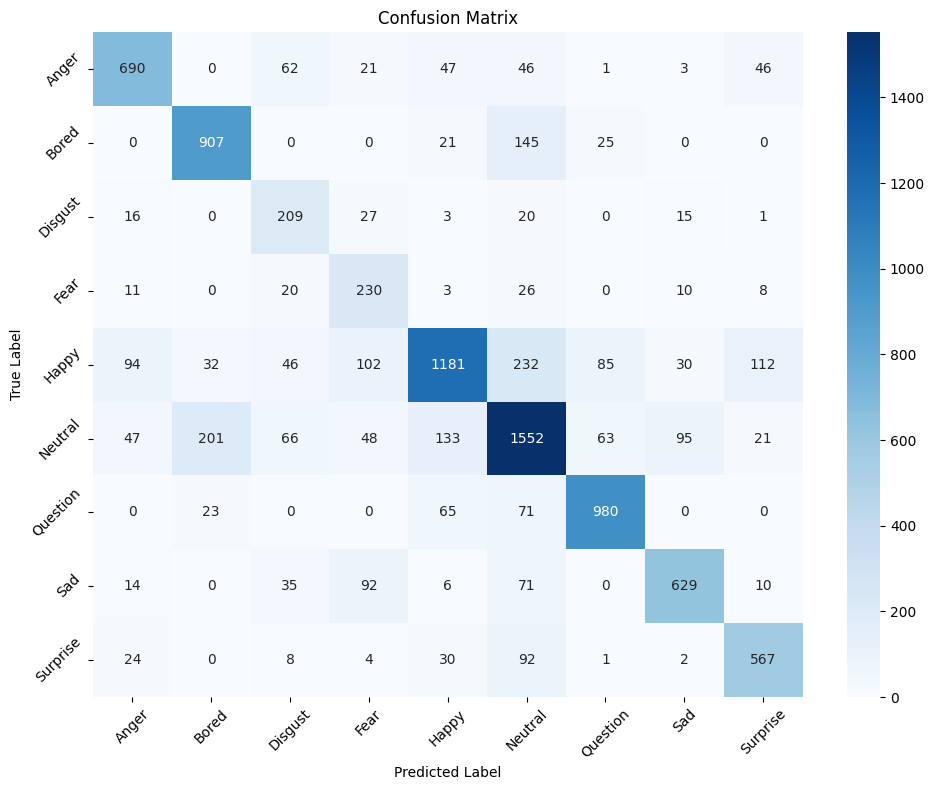

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=7
)